In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

Epoch 50, Loss: 0.000576
Epoch 100, Loss: 0.000249
Epoch 150, Loss: 0.000215
Epoch 200, Loss: 0.000191
Epoch 250, Loss: 0.000171
Epoch 300, Loss: 0.000155


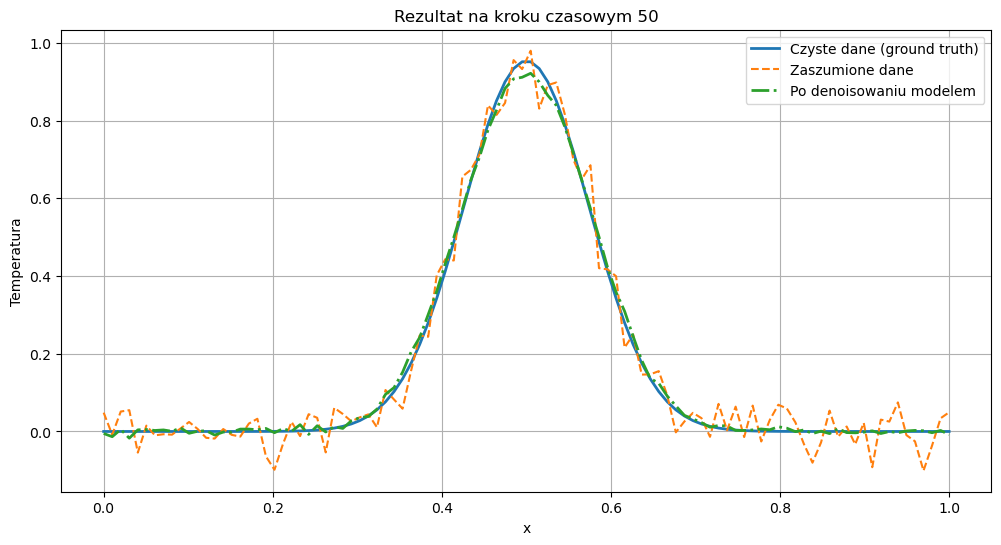

In [5]:
def heat_equation(u0, dx, dt, alpha, steps): 
    u = u0.copy()
    results = [u.copy()]
    for _ in range(steps):
        u[1:-1] = u[1:-1] + alpha * dt / dx**2 * (u[2:] - 2 * u[1:-1] + u[:-2])
        results.append(u.copy())
    return np.array(results)

nx = 100 # rozdzielczość siatki: liczba punktów w przestrzeni
dx = 1 / (nx - 1) # obliczamy odległość między punktami
alpha = 0.01 # współczynnik dyfuzji
dt = 0.0005 # krok czasowy
steps = 200 # ile kroków czasowych

x = np.linspace(0, 1, nx) # wektor o nx punktach rozłożonych między 0 i 1
u0 = np.exp(-100 * (x - 0.5)**2) # funkcja Gaussa, czyli warunek początkowy skupiony wokoł środka siatki 

clean_data = heat_equation(u0, dx, dt, alpha, steps)

noisy_data = clean_data + 0.05 * np.random.randn(*clean_data.shape)


class SimpleDenoiser(nn.Module):
    def __init__(self):
        super(SimpleDenoiser, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(nx, 128),
            nn.ReLU(),
            nn.Linear(128, nx)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleDenoiser().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

input_data = torch.tensor(noisy_data[:-1], dtype=torch.float32).to(device)
target_data = torch.tensor(clean_data[1:], dtype=torch.float32).to(device)


epochs = 300
for epoch in range(epochs):
    model.train()
    output = model(input_data)
    loss = loss_fn(output, target_data)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')


model.eval()
with torch.no_grad():
    denoised = model(input_data).cpu().numpy()


time_step = 50  

plt.figure(figsize=(12, 6))
plt.plot(x, clean_data[time_step], label='Czyste dane (ground truth)', linewidth=2)
plt.plot(x, noisy_data[time_step], label='Zaszumione dane', linestyle='--')
plt.plot(x, denoised[time_step-1], label='Po denoisowaniu modelem', linestyle='-.', linewidth=2)
plt.legend()
plt.title(f'Rezultat na kroku czasowym {time_step}')
plt.xlabel('x')
plt.ylabel('Temperatura')
plt.grid(True)
plt.show()


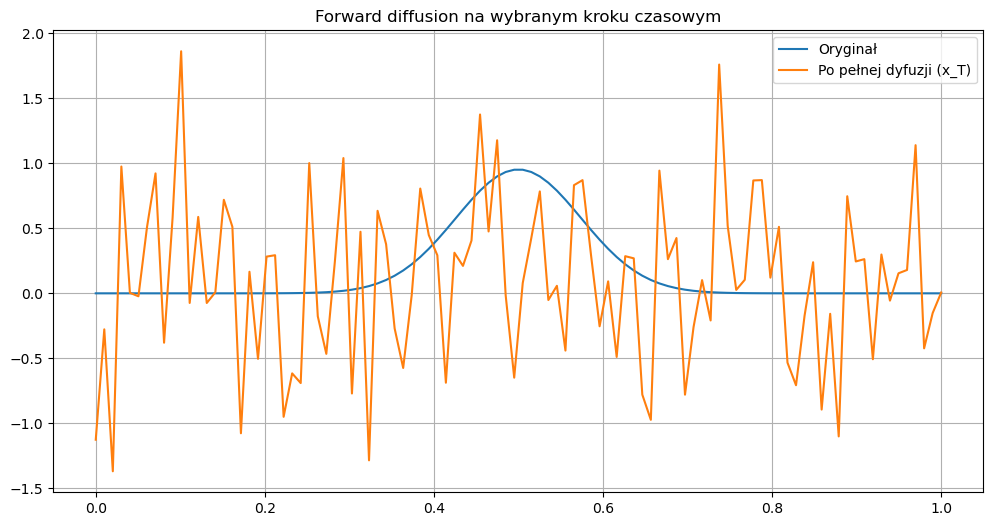

In [6]:
def forward_diffusion(x0, timesteps, beta=0.02):
    noise = np.random.randn(*x0.shape)
    alphas = 1 - beta * np.arange(1, timesteps + 1) / timesteps
    x_t = [x0]
    for alpha in alphas:
        x0 = alpha * x0 + (1 - alpha) * noise
        x_t.append(x0.copy())
    return np.array(x_t), noise

timesteps = 100
diffused_data, noise_added = forward_diffusion(clean_data, timesteps)

plt.figure(figsize=(12, 6))
plt.plot(x, clean_data[50], label='Oryginał')
plt.plot(x, diffused_data[timesteps, 50], label='Po pełnej dyfuzji (x_T)')
plt.title('Forward diffusion na wybranym kroku czasowym')
plt.legend()
plt.grid(True)
plt.show()


Epoch 50, Loss: 0.225301
Epoch 100, Loss: 0.189758
Epoch 150, Loss: 0.173337
Epoch 200, Loss: 0.163144
Epoch 250, Loss: 0.156546
Epoch 300, Loss: 0.151993
Epoch 350, Loss: 0.148516
Epoch 400, Loss: 0.145718
Epoch 450, Loss: 0.143737
Epoch 500, Loss: 0.141976
Epoch 550, Loss: 0.140871
Epoch 600, Loss: 0.139693
Epoch 650, Loss: 0.138693
Epoch 700, Loss: 0.137893
Epoch 750, Loss: 0.137679
Epoch 800, Loss: 0.136409
Epoch 850, Loss: 0.134818
Epoch 900, Loss: 0.134791
Epoch 950, Loss: 0.135137
Epoch 1000, Loss: 0.134481


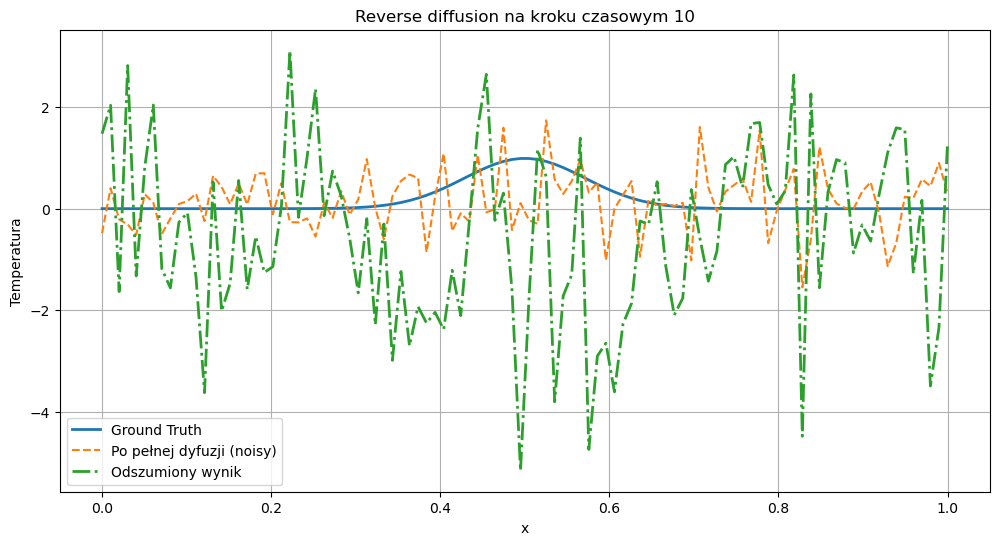

In [7]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(nx + 1, 128),
            nn.ReLU(),
            nn.Linear(128, nx)
        )

    def forward(self, x, t):
        t_input = torch.full((x.shape[0], 1), t, device=x.device)
        x_input = torch.cat([x, t_input], dim=1)
        return self.net(x_input)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Denoiser().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 1000

for epoch in range(epochs):
    total_loss = 0
    for t in range(1, timesteps):
        input_noisy = torch.tensor(diffused_data[t], dtype=torch.float32).to(device)
        true_clean = torch.tensor(clean_data, dtype=torch.float32).to(device)
        true_noise = torch.tensor(noise_added, dtype=torch.float32).to(device)

        pred_noise = model(input_noisy, t / timesteps)
        loss = loss_fn(pred_noise, true_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / timesteps:.6f}')


def reverse_diffusion(model, shape, timesteps):
    model.eval()
    x_t = torch.randn(shape, device=device)
    with torch.no_grad():
        for t in reversed(range(1, timesteps)):
            pred_noise = model(x_t, t / timesteps)
            alpha = 1 - 0.02 * t / timesteps
            x_t = (x_t - (1 - alpha) * pred_noise) / alpha
    return x_t.cpu().numpy()

denoised_result = reverse_diffusion(model, clean_data.shape, timesteps)

time_step = 10

plt.figure(figsize=(12, 6))
plt.plot(x, clean_data[time_step], label='Ground Truth', linewidth=2)
plt.plot(x, diffused_data[timesteps, time_step], label='Po pełnej dyfuzji (noisy)', linestyle='--')
plt.plot(x, denoised_result[time_step], label='Odszumiony wynik', linestyle='-.', linewidth=2)
plt.legend()
plt.title(f'Reverse diffusion na kroku czasowym {time_step}')
plt.xlabel('x')
plt.ylabel('Temperatura')
plt.grid(True)
plt.show()